In [181]:
import sys
from pathlib import Path
from copy import deepcopy
from collections import Counter
from random import randint
# from os.path import exists

# Add the path to the sys.path list
sys.path.append(Path(Path.cwd(), "..", "galfitlib").as_posix())

In [2]:
#from galfitlib.classes.components import *
from galfitlib.classes.containers import *
from galfitlib.functions.helper_functions import *
from galfitlib.pipeline.s2g_feedme_gen import *

In [3]:
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename
from scipy import fft
import numpy as np
import matplotlib.pyplot as plt

In [4]:
#Imports
import ipywidgets as widgets
from IPython.display import display
from IPython.display import Audio

In [5]:
import sounddevice as sd

In [6]:
# # From the twelve-tone tuning system
notes = [
    ['C0', 16.35],
    ['C#0/Db0', 17.32],
    ['D0', 18.35],
    ['D#0/Eb0', 19.45],
    ['E0', 20.60],
    ['F0', 21.83],
    ['F#0/Gb0', 23.12],
    ['G0', 24.50],
    ['G#0/Ab0', 25.96],
    ['A0', 27.50],
    ['A#0/Bb0', 29.14],
    ['B0', 30.87],
    ['C1', 32.70],
    ['C#1/Db1', 34.65],
    ['D1', 36.71],
    ['D#1/Eb1', 38.89],
    ['E1', 41.20],
    ['F1', 43.65],
    ['F#1/Gb1', 46.25],
    ['G1', 49.00],
    ['G#1/Ab1', 51.91],
    ['A1', 55.00],
    ['A#1/Bb1', 58.27],
    ['B1', 61.74],
    ['C2', 65.41],
    ['C#2/Db2', 69.30],
    ['D2', 73.42],
    ['D#2/Eb2', 77.78],
    ['E2', 82.41],
    ['F2', 87.31],
    ['F#2/Gb2', 92.50],
    ['G2', 98.00],
    ['G#2/Ab2', 103.83],
    ['A2', 110.00],
    ['A#2/Bb2', 116.54],
    ['B2', 123.47],
    ['C3', 130.81],
    ['C#3/Db3', 138.59],
    ['D3', 146.83],
    ['D#3/Eb3', 155.56],
    ['E3', 164.81],
    ['F3', 174.61],
    ['F#3/Gb3', 185.00],
    ['G3', 196.00],
    ['G#3/Ab3', 207.65],
    ['A3', 220.00],
    ['A#3/Bb3', 233.08],
    ['B3', 246.94],
    ['C4', 261.63],
    ['C#4/Db4', 277.18],
    ['D4', 293.66],
    ['D#4/Eb4', 311.13],
    ['E4', 329.63],
    ['F4', 349.23],
    ['F#4/Gb4', 369.99],
    ['G4', 392.00],
    ['G#4/Ab4', 415.30],
    ['A4', 440.00],
    ['A#4/Bb4', 466.16],
    ['B4', 493.88],
    ['C5', 523.25],
    ['C#5/Db5', 554.37],
    ['D5', 587.33],
    ['D#5/Eb5', 622.25],
    ['E5', 659.25],
    ['F5', 698.46],
    ['F#5/Gb5', 739.99],
    ['G5', 783.99],
    ['G#5/Ab5', 830.61],
    ['A5', 880.00],
    ['A#5/Bb5', 932.33],
    ['B5', 987.77],
    ['C6', 1046.50],
    ['C#6/Db6', 1108.73],
    ['D6', 1174.66],
    ['D#6/Eb6', 1244.51	],
    ['E6', 1318.51],
    ['F6', 1396.91],
    ['F#6/Gb6', 1479.98],
    ['G6', 1567.98],
    ['G#6/Ab6', 1661.22],
    ['A6', 1760.00	],
    ['A#6/Bb6', 1864.66],
    ['B6', 1975.53	],
    ['C7', 2093.00],
    ['C#7/Db7', 2217.46],
    ['D7', 2349.32],
    ['D#7/Eb7', 2489.02],
    ['E7', 2637.02],
    ['F7', 2793.83],
    ['F#7/Gb7 ', 2959.96],
    ['G7', 3135.96],
    ['G#7/Ab7', 3322.44],
    ['A7', 3520.00],
    ['A#7/Bb7', 3729.31],
    ['B7', 3951.07],
    ['C8', 4186.01],
    ['C#8/Db8', 4434.92],
    ['D8', 4698.63],
    ['D#8/Eb8', 4978.03],
    ['E8', 5274.04],
    ['F8', 5587.65],
    ['F#8/Gb8', 5919.91],
    ['G8', 6271.93],
    ['G#8/Ab8', 6644.88	],
    ['A8', 7040.00],
    ['A#8/Bb8', 7458.62],
    ['B8', 7902.13],
]

In [7]:
note_dict_ranges = {}
previous_tone_number = "0"
previous_name        = None
for name, freq in notes:
    name = name.replace("#", "").replace("b", "").strip()
    
    current_tone_number = name[-1]
    
    # There are gaps when jumping to different numbers
    if current_tone_number != previous_tone_number:
        note_dict_ranges[previous_name].append(freq)
        
    note_letter_1 = name
    note_letter_2 = None
    
    if "/" in name:
        note_letter_1, note_letter_2 = name.split("/")
        #note_letter_1 = note_letter_1[0]
        #note_letter_2 = note_letter_2[0]
        
        note_dict_ranges[note_letter_1].append(freq)
        note_dict_ranges[note_letter_2] = [freq]
        
    else:
        if note_letter_1 not in note_dict_ranges:
            note_dict_ranges[note_letter_1] = [freq]
        else:
            note_dict_ranges[note_letter_1].append(freq)
            
    previous_tone_number = current_tone_number
    previous_name        = name

In [8]:
#note_dict_ranges

In [9]:
#note_dict_rangesa
ranges_for_search = [                                                    
    {
        "start" : freqs[0],                      
        "end"   : freqs[-1],                           
        "value" : note
    }                        
    for note, freqs in note_dict_ranges.items()
]
#ranges_for_search

In [10]:
def binary_search_ranges(ranges, values : list) -> list[tuple[str, float]]:
    """
    Wrapper for binary search on a list of values in a list of ranges
    """
    def binary_search(ranges : list, value : float) -> tuple[str, float]:
        """
        Binary search for a value in a list of ranges
        Thanks to https://stackoverflow.com/a/65518827 for the code
        
        Parameters
        ----------
        ranges : list
            List of dictionaries containing the frequency ranges to search
        value : float
            Value to search for
            
        Returns
        -------
        str
            Note corresponding to the value
        float
            Difference between the value and the start of the frequency range
        """
    
        if len(ranges) == 1:
            if ranges[0]["start"] <= value <= ranges[0]["end"]:
                pass
            else:
                print(f"Value ({value:.2f}) not found in *any* range.")
                print(f"Choosing note: {ranges[0]['value']}")
                
            # Normalize the difference wrt the total length of the range
            # Maximum value is 1 so if a value is at the beyond the range, 
            # in the case of gaps (per above) it will be set to 1
            range_len = ranges[0]["end"] - ranges[0]["start"]
            return (
                ranges[0]["value"], 
                min(
                        (value - ranges[0]["start"])/range_len, 1
                )
            )
    
        mid = len(ranges) // 2
        if ranges[mid]["end"] < value:
            return binary_search(ranges[mid:], value)
        elif ranges[mid]["start"] > value:
            return binary_search(ranges[:mid], value)
        else:
            # Normalize the difference wrt the total length of the range
            range_len = ranges[mid]["end"] - ranges[mid]["start"]
            return (
                ranges[mid]["value"], 
                (value - ranges[mid]["start"])/range_len
            )
        
    return [binary_search(ranges_for_search, value) for value in values]
    #yield binary_search(ranges_for_search, value)

In [41]:
def note_converter(
        parameter,
        lambda_func, 
        modify_dict,
        note,
        *args
):
    """
    Performs the calculation to modify the galaxy property
    if the note is in the dictionary of notes to modify.
    """
    if note in modify_dict:
        parameter.value =  lambda_func(modify_dict[note], *args)

In [12]:
def bulge_modify(
        bulge_object       : Sersic,
        dict_modify_values : dict
):
    """
    Modifies the bulge object based on the dictionary of note values
    """
    # Magnitude is an inverse property
    magnitude_lambda        = lambda x : (12 - 16) * x       + 16
    # There is a relationship between effective radius and sersic index
    # so these two together do not follow the same pattern as the others
    effective_radius_lambda = lambda x : (4 - 2)   * (1 + x) + 2
    # Traditional bulge value is 4... so a minimum of 2 should be OK
    sersic_index_lambda     = lambda x : (5 - 2)   * (1 - x) + 2
    axis_ratio_lambda       = lambda x : (1 - 0.5) * (1 - x) + 0.5
    # Nor does this, but it's an angle, it gets a pass.
    position_angle_lambda   = lambda x : 2 * np.arcsin(x) * 180.0/np.pi
    
    note_converter(
            bulge_object.magnitude, 
            magnitude_lambda, 
            dict_modify_values, 
            '1'
    )
    
    note_converter(
            bulge_object.effective_radius, 
            effective_radius_lambda, 
            dict_modify_values, 
            '3'
    )
    
    note_converter(
            bulge_object.sersic_index, 
            sersic_index_lambda, 
            dict_modify_values, 
            '6'
    )
    
    note_converter(
            bulge_object.axis_ratio, 
            axis_ratio_lambda, 
            dict_modify_values, 
            '7'
    )
    
    note_converter(
            bulge_object.position_angle, 
            position_angle_lambda, 
            dict_modify_values, 
            '5'
    )

In [53]:
def disk_modify(
        disk_object        : Sersic,
        dict_modify_values : dict
):
    """
    Modifies the disk object based on the dictionary of note values
    """
    # Magnitude is an inverse property
    magnitude_lambda        = lambda x : (14 - 16) * x       + 16
    # There is a relationship between effective radius and sersic index
    # so these two together do not follow the same pattern as the others
    effective_radius_lambda = lambda x : (25 - 10)  * (1 + x) + 10
    # Traditional disk value is 1... so limiting it to 2 should give us some nice lookin' galaxies
    sersic_index_lambda     = lambda x : (2 - 0.25) * (1 - x) + 0.25
    axis_ratio_lambda       = lambda x : (1 - 0.5)  * x       + 0.5
    position_angle_lambda   = lambda x : 2 * np.arcsin(x) * 180.0/np.pi
    
    note_converter(
            disk_object.magnitude, 
            magnitude_lambda, 
            dict_modify_values, 
            '1'
    )
    
    note_converter(
            disk_object.effective_radius, 
            effective_radius_lambda, 
            dict_modify_values, 
            'RMS'
    )
    
    note_converter(
            disk_object.sersic_index, 
            sersic_index_lambda, 
            dict_modify_values, 
            '0'
    )
    
    note_converter(
            disk_object.axis_ratio, 
            axis_ratio_lambda, 
            dict_modify_values, 
            '2'
    )
    
    note_converter(
            disk_object.position_angle, 
            position_angle_lambda, 
            dict_modify_values, 
            '2'
    )

In [55]:
def arms_modify(
        arms_object        : Power,
        dict_modify_values : dict
):
    """
    Modifies the arms object based on the dictionary of note values
    """
    inner_radius_lambda       = lambda x : (15 - 0)   * (1 - x) + 0
    outer_radius_lambda       = lambda x : (15 - 0)   * (1 + x) + 25
    cumul_rot_lambda          = lambda x : 90 * np.pi/180 * np.arcsin(x) * 180.0/np.pi + 90
    powerlaw_index_lambda     = lambda x : (2.5 - -1) * (1 - x) + -1
    inclination_lambda        = lambda x : max(np.arcsin(x) * 180.0/np.pi, 65)
    sky_position_angle_lambda = lambda x : 2 * np.arcsin(x) * 180.0/np.pi
    
    note_converter(
            arms_object.inner_rad, 
            inner_radius_lambda, 
            dict_modify_values, 
            '5'
    )
    
    note_converter(
            arms_object.outer_rad, 
            outer_radius_lambda, 
            dict_modify_values, 
            'RMS'
    )
    
    note_converter(
            arms_object.cumul_rot, 
            cumul_rot_lambda, 
            dict_modify_values, 
            '3'
    )
    
    note_converter(
            arms_object.powerlaw_index, 
            powerlaw_index_lambda, 
            dict_modify_values, 
            '4'
    )
    
    note_converter(
            arms_object.inclination, 
            inclination_lambda, 
            dict_modify_values, 
            '6'
    )
    
    note_converter(
            arms_object.sky_position_angle, 
            sky_position_angle_lambda, 
            dict_modify_values, 
            '3'
    )

In [52]:
def fourier_modify(
        dict_modify_values : dict
):
    """
    Modifies the fourier object based on the dictionary of note values
    Of course, the Fourier modes always complicate things so this is
    much different than the previous.
    """
    num_fourier_modes_lambda = lambda x    : (5 - 1)   * (1 - x) + 1
    # formerly (0.05 - 0.001) * (1 - x) + 0.001
    amplitude_lambda         = lambda x, default : (0.75 + x) * default 
    
    if '1' in dict_modify_values:
        num_fourier_modes = num_fourier_modes_lambda(dict_modify_values['1'])
    else:
        num_fourier_modes = 2
        
    fourier_object = Fourier(num_fourier_modes)
    
    count = 5
    for Fmode in fourier_object.parameters.values():
        if isinstance(Fmode, FourierMode):
            note_converter(
                    mode, 
                    amplitude_lambda, 
                    dict_modify_values, 
                    str(count),
                    Fmode.amplitude
            )
        count += 1
    
    return fourier_object

In [26]:
def music_to_galaxy_properties(
        bulge_object       : Sersic,
        disk_object        : Sersic,
        arms_object        : Power,
        # fourier_object : Fourier,
        dict_modify_values : dict
):
    """
    KEY:
    PRIORITY - GALAXY PROPERTY
    
    BULGE
    2 – ‘Magnitude’ [10,16] -> Linearly [0,1] | Set: 15 | Direction: Longer -> Lower Value
    4 – ‘Effective Radius’ [0, 75] | Set: 3 | Direction: Longer -> Higher Value
    7 – ‘Sersic Index’ [0.1, 8] (linear-ish scaling) | Set: 1.0 | Direction: Longer -> Higher Value
    8 – ‘Axis Ratio’ [0.5, 1] | Set: 1.0 | Direction: Longer -> Lower Value
    6 – ‘Position Angle’ [0.5, 1] | Set: 1.0 | Direction: Longer -> Lower Value
    
    DISK
    2   – ‘Magnitude’ [10, 16] -> Linearly [0, 1] | Set: 15 | Direction: Longer -> Lower Value
    RMS – ‘Eff_Rad’ [0, 75] | Set: 20 | Direction: Longer -> Higher Value
    1   – ‘Sersic_Index’ [0.1, 8] (linear-ish scaling) | Set: 1.0 | Direction: Longer -> Higher Value
    3   – ‘Pos_Angle’ [0, 180] -> [0,1] Sin(theta/2) | Set: 0 | Direction: Longer -> Higher Value
    4   – ‘Axis_Ratio’ [0.5, 1] | Set: 1.0 | Direction: Longer -> Lower Value
    
    ARMS
    6   - spiral inner radius
    RMS - spiral outer radius
    4   - cumulative rotation
    5   - spiral power law
    7   - inclination
    6   - position angle
    
    FOURIER
    3   - # of fourier modes
    9   - strength of fourier modes
    """
    # Modification of the galaxy properties based on the music notes
    # As (generally) follows:
    # (max_value - min_value) * (1 +/- normalized_note_value) + min_value 

    # BULGE
    bulge_modify(bulge_object, dict_modify_values)
    
    # DISK
    disk_modify(disk_object, dict_modify_values)
    
    # ARMS
    arms_modify(arms_object, dict_modify_values)
        
    # FOURIER
    # The number of arms depends on the song so the fourier object operates differently
    return fourier_modify(dict_modify_values)

In [27]:
g_prefix = "galaxy"
g_number = 0

cwd = Path.cwd()

IN_DIR  = pj(cwd, "music-in")
TMP_DIR = pj(cwd, "music-tmp")
OUT_DIR = pj(cwd, "music-out")

previous = False

In [28]:
def rms(data, width):
    """
    audioop.rms() using numpy; since audioop will be deprecated
    Thanks https://stackoverflow.com/q/9763471 !
    """
    
    if len(data) == 0: 
        return None
    
    from_type = (np.int8, np.int16, np.int32)[width//2]
    d         = np.frombuffer(data, from_type).astype(float)
    return int(np.sqrt(np.mean(d**2)))

In [29]:
# Function to update the array image when slider value changes
def update_image_array(change):
    # Update the image data based on the slider value
    new_image_data_array = image_data_array * change.new

    # Update the array image with new data
    image_array.set_data(new_image_data_array)

    # Redraw the figure
    fig.canvas.draw()

In [30]:
import librosa
x, sr = librosa.load('brown_alma_mater.mp3')

In [31]:
# import pygame
# 
# def play_audio(file_path):
#     # Initialize Pygame mixer
#     pygame.mixer.init()
# 
#     # Load the audio file
#     pygame.mixer.music.load(file_path)
# 
#     # Play the audio file
#     pygame.mixer.music.play()
# 
#     # Keep the script running while the audio is playing
#     while pygame.mixer.music.get_busy():
#         pygame.time.Clock().tick(10)
# 
# 
# audio_file = "brown_alma_mater.mp3"
# play_audio(audio_file)

In [32]:
%matplotlib inline

Value (689.27) not found in *any* range.
Choosing note: E5
Value (690.91) not found in *any* range.
Choosing note: E5
Value (683.28) not found in *any* range.
Choosing note: E5


<Figure size 640x480 with 0 Axes>

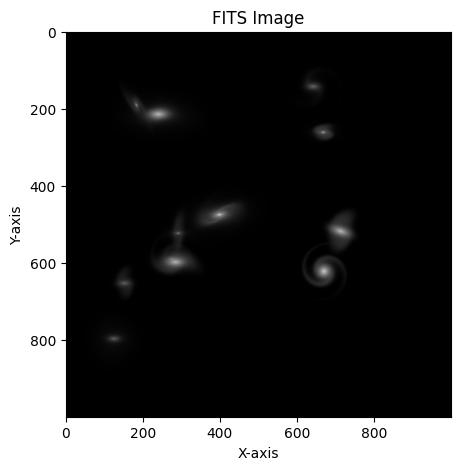

In [227]:
count = 0
g_number = 0
gname = "template"

height = 1000
width  = 1000
# square
model_dim    = 250
model_offset = model_dim//2

image_array = np.zeros((height, width))

while g_number == 0:
    plt.clf()

    if not exists(pj(OUT_DIR, gname)):
        pj(OUT_DIR, gname).mkdir()

    feedme_0          = pj(OUT_DIR, gname, f"{gname}.in")
    input_filename_0  = pj(IN_DIR, f"{gname}.fits")
    output_filename_0 = pj(OUT_DIR, gname, f"{gname}.fits")
    
    x     = 10000
    count = 0
    filename = "brown_alma_mater.mp3"
    list_o_notes = []
    volumes      = []
    all_models   = []
    
    while x != 0 and count < 1:
        # x = int(input("Waiting..."))
        #sr = 48000
        #duration = 6
        signal, sr = librosa.load(filename)
        t = np.arange(librosa.get_duration(path = filename), step = 1/sr)
        #Nsamples = int(duration*sr)
        # Cmaj = sd.rec(Nsamples, samplerate=sr, channels=1, blocking=True)[:,0]#dur5
        
         #np.arange(Nsamples)/sr
        #extracting chord and duration
        #ignore first 1 seconds
        # blur(abs(signal)) to find peaks
        # FT first peak to get chord
        # output as string
        # time between this and last peak, output this too

        ignore = 0.5 # seconds
        signal = signal[t > 0.5]
        t      = t[t > 0.5]
        
        s = 0.01
        t_step_size = 5 * sr
        t_initial   = int(ignore * sr) + t_step_size
        
        for t_step in range(t_initial, len(t), t_step_size):
            
            # Want 5 but add 1 for check for duplicates otherwise things get thrown off
            num_notes_to_pick  = 5 + 1
            num_notes_to_check = 2*num_notes_to_pick
            
            #t_step = t[i_step] - t[i_step - i_step_size]
            cutsignal = signal[t_step - t_step_size : t_step]
            
            blurProfile = (1/np.sqrt(2*np.pi*s**2))*np.exp(-0.5*(np.linspace(-3*s, 3*s, int(6*s*sr))/s)**2)
    
            signalBlurred = np.convolve(cutsignal**2, blurProfile, mode='same')
    
            chordrange = signalBlurred>100
            if not np.any(chordrange):
                continue
    
            FT    = fft.fft(cutsignal[chordrange])
            freqs = fft.fftfreq(len(cutsignal[chordrange]), d=1/sr)
    
            FT    = FT[freqs >= 0]
            freqs = freqs[freqs >= 0]
            #fmask = (freqs>10)&(freqs<2000)
    
            # noteBins = 220*(2**((np.arange(12*3)-0.5)/12)) # starting from A below middle
            
            # Very basic peak detection method
            all_peaks      = freqs[np.argsort(FT)]
            selected_peaks = all_peaks[-num_notes_to_pick:]
            while len(set(selected_peaks)) < num_notes_to_pick:
                num_notes_to_check += 1
                selected_peaks = all_peaks[-num_notes_to_check:]
                
            peak_notes = binary_search_ranges(ranges_for_search, selected_peaks)
            list_o_notes.append(peak_notes)
            
            volumes.append(rms(cutsignal, 2))
            
            # plt.clf()
            # fig,ax = plt.subplots()
            # ax.plot(freqs[fmask], np.abs(FT[fmask])**2)
            # plt.show()
            
            #break
        
        # Flatten the list of lists of notes for Counter
        flattened_list_o_notes = [note[0] for sublist in list_o_notes for note in sublist]
        # Counter does not sort by frequency, so we need to sort it
        sorted_counter = {
            k : v for k, v in sorted(
                    Counter(flattened_list_o_notes).items(), key=lambda item: item[1], 
                    reverse = True
            )
        }
        
        note_priority_map      = {
            note : priority_num 
            for priority_num, note in enumerate(
                    sorted_counter.keys()
            )
        }
        
        # Normalize volumes
        volumes      = np.array(volumes)
        max_volume   = np.max(volumes)
        min_volume   = np.min(volumes)
        
        norm_volumes = (volumes - min_volume)/(max_volume - min_volume)
        
        for i, (notes_chunk, norm_volume) in enumerate(zip(list_o_notes, norm_volumes)):
            
            dummy_array = np.zeros((height, width))
            
            feedme = feedme_0.with_stem(f"{feedme_0.stem}_{i}")
            
            position = (model_offset, model_offset)
            
            bulge = Sersic(
                    component_number = 1,
                    position = position,
            )

            disk  = Sersic(
                    component_number = 2,
                    position = position,
            )

            arms  = Power(
                    component_number = 2,
                    position = position,
            )
            
            output_filename = output_filename_0.with_stem(f"{output_filename_0.stem}_out_{i}")
            header = GalfitHeader(
                    galaxy_name = gname,
                    input_image = input_filename_0,
                    output_image = output_filename,
                    optimize = 1,
                    region_to_fit = (
                        0, 
                        model_dim, 
                        0, 
                        model_dim
                    )
            )
            
            # Normalized delta refers to the normalized value 
            # (w.r.t the length of the range for a note) 
            # of the difference between the note frequency 
            # and the start of the note's range.
            priority_numbers_and_norm_delta = {
                str(note_priority_map[note]) : norm_delta 
                for note, norm_delta in notes_chunk
            }
            
            priority_numbers_and_norm_delta['RMS'] = norm_volume
            
            fourier = music_to_galaxy_properties(
                    bulge_object       = bulge,
                    disk_object        = disk,
                    arms_object        = arms,
                    dict_modify_values = priority_numbers_and_norm_delta
            )
            fourier.component_number = 2
            
            galaxy_feedme = FeedmeContainer(
                    path_to_feedme = feedme, 
                    header  = header,
                    bulge   = bulge,
                    disk    = disk,
                    arms    = arms,
                    fourier = fourier,
                    sky     = Sky(3),
                    load_default = False
            )

            galaxy_feedme.to_file()

            #print(galaxy_feedme)
            process = sp(f"{RUN_GALFIT} {feedme}")
            
            # Open the FITS file
            fits_file = fits.open(output_filename)
    
            # Extract the image data from the FITS file
            image_data_fits     = fits_file[0].data - galaxy_feedme.sky.sky_background.value
            new_image_data_fits = deepcopy(image_data_fits)
            
            x_pos = randint(0, width  - model_dim)
            y_pos = randint(0, height - model_dim)
            
            dummy_array[x_pos : x_pos + model_dim, y_pos : y_pos + model_dim] = new_image_data_fits
            image_array += dummy_array
    
            #image_data_array = fits_file[1].data
    
            # Close the FITS file
            fits_file.close()
        
        # Appending a logarithmic transformation of the image data
        # for display purposes
        # scaling_constant = 255/np.log(1+np.max(new_image_data_fits))
        # all_models.append(scaling_constant * np.log(1 + new_image_data_fits))
            
        # Create a figure and subplots
        fig, ax1 = plt.subplots(1, 1, figsize=(10, 5))

        # Display the FITS image
        image_fits = ax1.imshow(np.log(1 + image_array), cmap='gray')

        # Create a slider widget for the FITS image
        # slider_fits = widgets.FloatSlider(value = 1.0, min = 0.0, max = 2.0, step=0.01, description='FITS Scale:', continuous_update=True)

        # Function to update the FITS image when slider value changes
        def update_image_fits(change):
            # Update the image data based on the slider value
            new_image_data_fits = change.new * np.log(1 + image_data_fits)

            # Update the FITS image with new data
            image_fits.set_data(new_image_data_fits)

            # Redraw the figure
            fig.canvas.draw()

        # Attach the update_image_fits function to the FITS slider's value change event
        # slider_fits.observe(update_image_fits, 'value')

        # Display the slider widgets
        # display(widgets.HBox([slider_fits])) #, slider_array]))

        # Add any additional customization you need to the subplots
        ax1.set_title('FITS Image')
        ax1.set_xlabel('X-axis')
        ax1.set_ylabel('Y-axis')

        # Show the plot
        plt.show()
            
            
        # x = input()
        break
        
    break
    #g_number += 1

In [179]:
# from PIL import Image
# 
# width = 1000
# height = 1000
# mosaic_size = (width, height)
# 
# # TODO: Create as animation, with each frame being a different galaxy
# # can do this by adding each FITS to a numpy array
# canvas = Image.new('L', mosaic_size, color = 'black')
# 
# transparency_cutoff = 15
# for model_galaxy in all_models:
#     x_pos = randint(0, width  - 150)
#     y_pos = randint(0, height - 150)
#         
#     image_galaxy = Image.fromarray(model_galaxy).convert("LA")
#     alpha_array  = np.zeros_like(model_galaxy)
#     #alpha_array[model_galaxy < np.log(15)]  = 0
#     alpha_array[model_galaxy >= np.log(100)]  = 255
#     
#     for i, alpha_value in enumerate(range(transparency_cutoff, 200, 5)):
#         conditions = (
#                 (model_galaxy >= np.log((i + 1)*transparency_cutoff)) & 
#                 (model_galaxy < np.log((i + 2) * transparency_cutoff))
#         )
#         alpha_array[conditions] = alpha_value
#     
#     alpha_image = Image.fromarray(alpha_array).convert("L")    
#     
#     canvas.paste(image_galaxy, (x_pos, y_pos), alpha_image)
#         
# #canvas.save("mosaic.png")
# canvas

In [177]:
np.shape(model_galaxy)
#alpha_array = np.array(alpha_array)
#alpha_array[alpha_array >= 5]

(147, 147)

In [180]:
#plt.clf()
#fig,ax = plt.subplots()
#ax.imshow(alpha_image, cmap='gray')
#plt.show()